# NetCDF Zarr Multi-Variable Sequential Recipe: NOAA World Ocean Atlas

This recipe is a little bit more complicated than the {doc}`netcdf_zarr_sequential`.
You shold probably review that one first; here we will skip the basics.

For this example, we will use data from NOAA's [World Ocean Atlas](https://www.ncei.noaa.gov/products/world-ocean-atlas).
As we can see from the [data access page](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/bin/woa18.pl), the dataset is spread over many different files.
What's important here is that:
- There is a time sequence (month) to the files.
- Different variables live in different files.

Because our dataset is spread over muliple files, we will have to use a more complex File Pattern than the previous example.

## Step 1: Get to know your source data

This step can't be skipped! It's impossible to write a recipe if you don't understand intimately how the source data are organized.
World Ocean Atlass has eight different variables: Temperature, Salinity, Dissolved Oxygen, Percent Oxygen Saturation, Apparent Oxygen Utilization, Silicate, Phosphate, Nitrate.
Each variable has a page that looks like this:

![screenshot from NCEI website](ncei-woa-screenshot.png)

For the purpose of this tutorial, we will use the 5-degree resolution monthly data.
We can follow the links to finally find an HTTP download link for a single month of data.

In [1]:
download_url = 'https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc'

Let's download it and try to open it with xarray.

In [2]:
! wget https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc

--2023-02-27 10:13:30--  https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.171, 205.167.25.172, 205.167.25.168, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.171|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 2389903 (2.3M) [application/x-netcdf]
Saving to: ‘woa18_decav_t01_5d.nc.8’

woa18_decav_t01_5d. 100%[===================>]   2.28M   462KB/s    in 5.3s    

2023-02-27 10:13:36 (437 KB/s) - ‘woa18_decav_t01_5d.nc.8’ saved [2389903/2389903]



In [3]:
import xarray as xr

try:
    ds = xr.open_dataset("woa18_decav_t01_5d.nc")
except ValueError as e:
    print(e)

Failed to decode variable 'time': unable to decode time units 'months since 1955-01-01 00:00:00' with 'the default calendar'. Try opening your dataset with decode_times=False or installing cftime if it is not installed.


❗️ Oh no, we got an error!

This is a very common problem. The calendar is encoded using "months since" units, which are ambiguous in the [CF Conventions](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.html#calendar). (The precise length of a month is variable by month an year.)

We will follow the advice and do

In [4]:
ds = xr.open_dataset("woa18_decav_t01_5d.nc", decode_times=False)
ds

<xarray.Dataset>
Dimensions:             (lat: 36, nbounds: 2, lon: 72, depth: 57, time: 1)
Coordinates:
  * lat                 (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon                 (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) float32 372.5
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         PRERELEASE Climatological mean temperatu...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   http://www.nodc.noaa.gov/OC5/WOA18/pr_wo...
    date_created:                    2018-02-19 
    date_modified:                   2018-02-19

In [5]:
ds.time

<xarray.DataArray 'time' (time: 1)>
array([372.5], dtype=float32)
Coordinates:
  * time     (time) float32 372.5
Attributes:
    standard_name:  time
    long_name:      time
    units:          months since 1955-01-01 00:00:00
    axis:           T
    climatology:    climatology_bounds

We have opened the data, but the time coordinate is just a number, not an actual datetime object.
We can work around this issue by explicitly specifying the `360_day` calendar (in which every month is assumed to have 30 days).

In [6]:
ds.time.attrs['calendar'] = '360_day'
ds = xr.decode_cf(ds)
ds

<xarray.Dataset>
Dimensions:             (lat: 36, nbounds: 2, lon: 72, depth: 57, time: 1)
Coordinates:
  * lat                 (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon                 (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) object 1986-01-16 00:00:00
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         PRERELEASE Climatological mean temperatu...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   http://www.nodc.noaa.gov/OC5/WOA18/pr_wo...
    date_created:                    2018-02-19 
    date_modified:                   2018-02-19

In [7]:
ds.time

<xarray.DataArray 'time' (time: 1)>
array([cftime.Datetime360Day(1986, 1, 16, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1986-01-16 00:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T
    climatology:    climatology_bounds

We will need this trick for later.

## Step 2: Define the File Pattern

We can browse through the files on the website and see how they are organized.

```
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t02_5d.nc
...
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/salinity/decav/5deg/woa18_decav_s01_5d.nc
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/salinity/decav/5deg/woa18_decav_s02_5d.nc
...
```

From this we can deduce the general pattern.
We write a function to return the correct filename for a given variable / month combination.

In [8]:
# Here it is important that the function argument name "time" match
# the name of the  dataset dimension "time"
def format_function(variable, time):
    return ("https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/"
            f"{variable}/decav/5deg/woa18_decav_{variable[0]}{time:02d}_5d.nc")

format_function("temperature", 2)

'https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t02_5d.nc'

Now we turn this into a `FilePattern` object.
This pattern has two distinct `combine_dims`: variable name and month.
We want to merge over variable names and concatenate over months. 

In [9]:
from pangeo_forge_recipes import patterns

variable_merge_dim = patterns.MergeDim("variable", keys=["temperature", "salinity"])

# Here it is important that the ConcatDim name "time" match the name of the 
# dataset dimension "time" (and the argument name in format_function)
month_concat_dim = patterns.ConcatDim("time", keys=list(range(1, 13)), nitems_per_file=1)

pattern = patterns.FilePattern(format_function, variable_merge_dim, month_concat_dim)
pattern

<FilePattern {'variable': 2, 'time': 12}>

## Step 3: Write the Recipe

Now that we have a `FilePattern`, we are ready to write our recipe. As described in {doc}`netcdf_zarr_sequential`, a recipe is defined as a pipeline of [Apache Beam transforms](https://beam.apache.org/documentation/programming-guide/#transforms) applied to the data collection associated with a `FilePattern`.

First, we'll import the transforms provided by Pangeo Forge that may be used to transform a `FilePattern` collection into a Zarr store.

In [10]:
import apache_beam as beam
from pangeo_forge_recipes.transforms import OpenURLWithFSSpec, OpenWithXarray, StoreToZarr

### Define an Input Preprocessor
Above we noted that the time was encoded wrong in the original data.
We might have also noticed that many variables that seems like coordinates (e.g. `lat_bnds`) were in the Data Variables part of the dataset.
We will write a Beam transform that fixes both these issues. This is achieved by creating a [composite transform](https://beam.apache.org/documentation/programming-guide/#composite-transform-creation), which is a subclass of the `apache_beam.PTransform` class that overrides the `expand()` method to specify the actual processing logic. 

In this example:
* `expand()` operates on an `apache_beam.PCollection`, performing a one-to-one mapping using [`apache_beam.Map`](https://beam.apache.org/documentation/programming-guide/#pardo) of input elements to output elements, i.e. for each input element, it applies `_fix_encoding_and_attrs()` that produces exactly one output element.
* As the preprocessor transform will be preceded by the `OpenWithXarray` transform in the pipeline, each input collection element will be a `pangeo_forge_recipes.transforms.Indexed[T]`. In this case each tuple will contain an index and an `xarray.Dataset`. The output tuple will contain the original index and the preprocessed `Dataset`.

In [11]:
from pangeo_forge_recipes.transforms import Indexed, T

class FixEncodingAttrs(beam.PTransform):
    """
    Fix issues in retrieved data.
    """

    @staticmethod
    def _fix_encoding_and_attrs(item: Indexed[T]) -> Indexed[T]:
        index, ds = item
        ds.time.attrs['calendar'] = '360_day'
        ds = xr.decode_cf(ds)
        ds = ds.set_coords(['crs', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'])
        return index, ds

    def expand(self, pcoll: beam.PCollection) -> beam.PCollection:
        return pcoll | beam.Map(self._fix_encoding_and_attrs)

### Define the Recipe Object
The recipe pipeline of transforms applied to `pattern` is similar to that described in {doc}`netcdf_zarr_sequential`, with the following modifications:
1. Due to the decoding issue described earlier, `decode_times=false` is specified to `OpenWithXarray`.
1. The new preprocessing transform `FixEncodingAttrs` is included in the pipeline.

A place for our data to go

In [12]:
import os
from tempfile import TemporaryDirectory
td = TemporaryDirectory()
target_root = td.name
store_name = "output.zarr"
target_store = os.path.join(target_root, store_name)
target_store

'/tmp/tmpmkk0h21h/output.zarr'

In [13]:
transforms = (
    beam.Create(pattern.items())
    | OpenURLWithFSSpec()
    | OpenWithXarray(file_type=pattern.file_type, xarray_open_kwargs=dict(decode_times=False))
    | FixEncodingAttrs() # New preprocessor
    | StoreToZarr(
        store_name=store_name,
        target_root=target_root,
        combine_dims=pattern.combine_dim_keys,
    )
)
transforms

<_ChainedPTransform(PTransform) label=[Create|OpenURLWithFSSpec|OpenWithXarray|FixEncodingAttrs|StoreToZarr] at 0x7fed26e108b0>

## Step 4: Run the Recipe

Execute the recipe pipeline using Beam.

In [14]:
with beam.Pipeline() as p:
    p | transforms

/home/derek/anaconda3/envs/forgerunner/lib/python3.9/site-packages/xarray/core/dataset.py:2081: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore
/home/derek/anaconda3/envs/forgerunner/lib/python3.9/site-packages/xarray/core/dataset.py:2081: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore


## Step 5: Check the Target

All the data should be there!

In [15]:
ds = xr.open_zarr(target_store)
ds

<xarray.Dataset>
Dimensions:             (time: 12, nbounds: 2, depth: 57, lat: 36, lon: 72)
Coordinates:
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    crs                 int32 ...
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(57, 2), meta=np.ndarray>
  * lat                 (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(36, 2), meta=np.ndarray>
  * lon                 (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(72, 2), meta=np.ndarray>
  * time                (time) float32 372.5 373.5 374.5 ... 381.5 382.5 383.5
Dimensions without coordinates: nbounds
Data variables:
    s_dd                (time, depth, lat, lon) int32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    s_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    s_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    s_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_dd                (time, depth, lat, lon) int32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                     CF-1.6, ACDD-1.3
    cdm_data_type:                   Grid
    comment:                         global climatology as part of the World ...
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    creator_email:                   NCEI.info@noaa.gov
    ...                              ...
    publisher_type:                  institution
    publisher_url:                   http://www.ncei.noaa.gov/
    sea_name:                        World-Wide Distribution
    standard_name_vocabulary:        CF Standard Name Table v49
    time_coverage_duration:          P63Y
    time_coverage_resolution:        P01M

Just to check, we will make a plot.

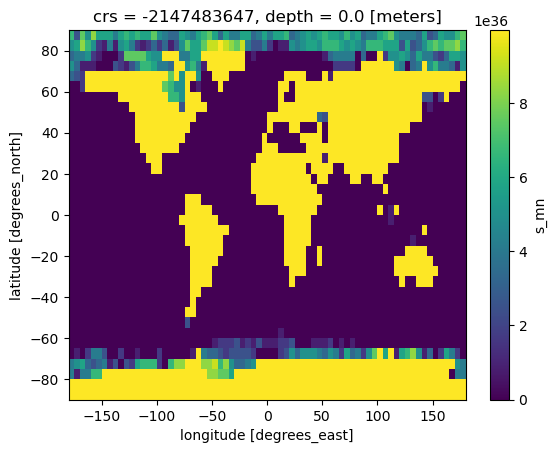

In [16]:
ds.s_mn.isel(depth=0).mean(dim='time').plot()

🎉 Yay! Our recipe worked!